# **PROYECTO FINAL DE MÉTODOS NUMÉRICOS Y OPTIMIZACIÓN**

|             NOMBRE             | USUARIO GITHUB |
|:------------------------------:|:--------------:|
|     Joel Jaramillo Pacheco     |  joelitam2021  |
|    Miguel Ángel Reyes Retana   |  rrmiguel-2401 |
| Mónica Altagracia García López |   mogarcia62   |
|  Rodrigo Ivan Juárez Jaramillo |     ro-juja    |

De una competencia realizada en [Kaggle: Traveling Santa Problem](https://www.kaggle.com/c/traveling-santa-problem/data?select=santa_cities.csv), 

El reto de esta competencia es encontrar la solución a un problema de optimización muy importante: Santa Claus necesita de nuestra ayudar para elegir la ruta que toma a la hora de entregar regalos en todo el mundo. El gran reto en este problema es encontrar caminos que minimicen las distancias a través de un conjunto de chimeneas. 

Como nos comentó el profesor Erick Palacios, el problema de Santa Claus es muy parecido al problema del vendedor viajero. Desde esa perspectiva como equipo, nos pareció una buena idea para abordar el problema de optimización. 

Para desarrollar el problema contamos con una base de datos que contienen diferentes puntos, en total 150,000 diferentes puntos que representan las diferentes chimeneas por las cuales tiene que aterrizar el señor Claus.

Para desarrollar el código, nos basamos fuertemente en el código implementado en el siguiente [notebook](https://colab.research.google.com/drive/1LVEwi94vlyyL19NWMc_oePVhdGkQAlG3#scrollTo=pze9ac-PkHXw), de un autor desconocido. 


In [19]:
#!pip install geopandas
#!pip install geopy

In [37]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import random



from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from geopy import distance 

In [38]:
random.seed(500)

In [42]:
cities = pd.read_csv('santa_cities.csv')

In [43]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      150000 non-null  int64
 1   x       150000 non-null  int64
 2   y       150000 non-null  int64
dtypes: int64(3)
memory usage: 3.4 MB


In [44]:
gdf = geopandas.GeoDataFrame(
    cities, geometry=geopandas.points_from_xy(cities.x, cities.y))

In [45]:
cities

,id,x,y,geometry
0,0,4360,6178,POINT (4360.000 6178.000)
1,1,10906,14956,POINT (10906.000 14956.000)
2,2,5071,8963,POINT (5071.000 8963.000)
3,3,13853,4105,POINT (13853.000 4105.000)
4,4,18885,3168,POINT (18885.000 3168.000)
...,...,...,...,...
149995,149995,7585,1056,POINT (7585.000 1056.000)
149996,149996,13993,1775,POINT (13993.000 1775.000)
149997,149997,13820,16485,POINT (13820.000 16485.000)
149998,149998,16927,595,POINT (16927.000 595.000)


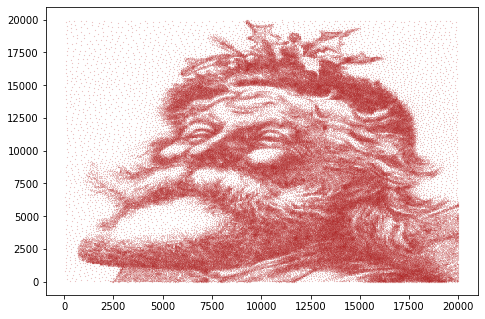

In [46]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(cities.x, cities.y, color='firebrick', s=.01)
plt.show()

Sin embargo, como es bien sabido, los niños que se portan bien son los favoritos de Santa Claus, por lo cual, Santa, al ver que tiene tantos niños que visitar, decide sacar la Famosa Santa's list. En dicha Lista, Santa se ha encargado de calificar el comportamiento de todos los niños del 1 al 10. 

Para simular las calificaciones de la lista de Santa, suponemos que los niños tiene en general un comportamiento regular, es decir, de 5. Pocos son los niños que sacan 10 y pocos son los niños que se portan demasiado mal. A cada chimenea le agregaremos una calificación y Santa escogerá primero a los niños con 9 o más de calificación en comportamiento y así sucesivamente de forma descendente.

Tomando como referencia al notebook de [mTSP_en.ipynb](https://colab.research.google.com/github/cvxpy/cvxpy/blob/master/examples/notebooks/WWW/mTSP_en.ipynb#scrollTo=KVdBD7b1PDw6)

Intentaremos replicar el ejemplo de un Vendedor Viajero: Example for a single Traveling Salesman

En este primer data frame, simularemos las calificaciones de comportamiento de la lista de Santa de las chimeneas de los niños.

In [47]:
np.random.seed(12345)
mu, sigma = 5, 1.12
s = np.random.normal(mu, sigma, 150000)
df=pd.DataFrame(s)
df = df.rename(columns = {0: 'behavior'}, inplace = False)

In [48]:
df.describe()

,behavior
count,150000.000000
mean,4.999501
std,1.121175
min,0.182210
25%,4.241572
50%,4.999441
75%,5.750439
max,10.019068


Tomando en cuenta los scores de behavior, Santa Claus quiere darle sus regalos a los niños que tengan un behavior mayor a 8

In [49]:
cities_behavior=pd.concat([cities, df], axis=1)

In [50]:
cities_behavior_9=cities_behavior[cities_behavior['behavior']>9]

In [51]:
cities_behavior_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 391 to 142621
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        24 non-null     int64   
 1   x         24 non-null     int64   
 2   y         24 non-null     int64   
 3   geometry  24 non-null     geometry
 4   behavior  24 non-null     float64 
dtypes: float64(1), geometry(1), int64(3)
memory usage: 1.1 KB


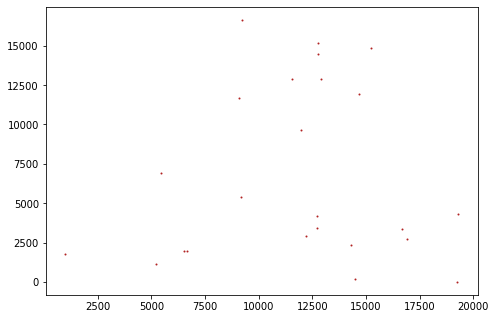

In [52]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(cities_behavior_9.x, cities_behavior_9.y, color='firebrick', s=1)
plt.show()

In [53]:
#create n x d matrix (n=observations, d=dimensions)
A=cities_behavior_9[['x', 'y']].to_numpy().T

In [54]:
A

array([[12725, 16693, 14671, 15215,  6672, 12210,  5455, 12749, 19301,
         9195, 16916, 14472, 12720,  6513, 14294, 12751, 12888, 11557,
         5207,   997, 11973,  9218,  9084, 19248],
       [ 3429,  3380, 11910, 14849,  1988,  2910,  6889, 14478,  4321,
         5395,  2732,   164,  4160,  1956,  2339, 15185, 12895, 12872,
         1162,  1772,  9641, 16645, 11697,    12]])

In [55]:
df=cities_behavior_9[['x','y']]


In [56]:
#Creamos matriz de distancias:
C=pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

In [57]:
X = cp.Variable(C.shape, boolean=True)
n = len(C)
u = cp.Variable(n, integer=True)
ones = np.ones((n,1))

In [58]:
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

In [59]:
constraints = []
constraints += [X @ ones == ones]
constraints += [X.T @ ones == ones]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

u_i , u_j son restricciones para la eliminación de subtours

In [60]:
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

In [61]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

Long-step dual simplex will be used


74602.63534840156

In [24]:
#Transformamos la solución a un camino
X_sol = np.argwhere(X.value==1)
orden = X_sol[0].tolist()

for i in range(1, n):
    row = orden[-1]
    orden.append(X_sol[row,1])

#Mostramos el camino óptimo:
print('El camino es:\n')
print( ' => '.join(map(str, orden)))

El camino es:

0 => 12 => 18 => 17 => 8 => 3 => 21 => 24 => 19 => 23 => 11 => 4 => 1 => 14 => 10 => 6 => 22 => 9 => 5 => 7 => 15 => 13 => 2 => 20 => 16 => 0


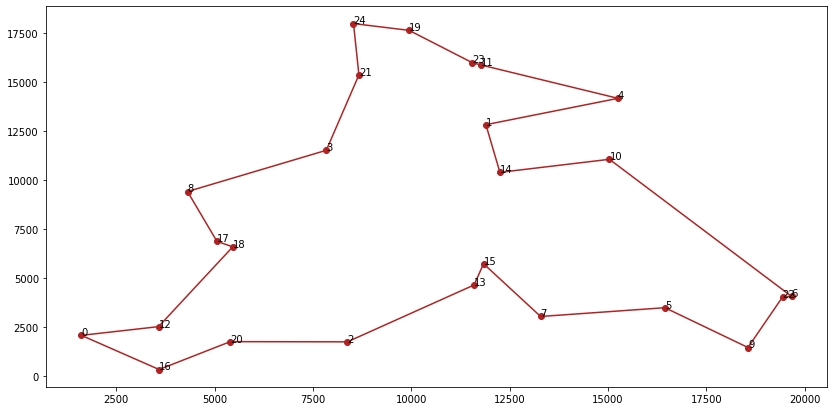

In [25]:
#Obtenemos coordenadas X Y:
xy_cords=np.array(cities_behavior_9[['x', 'y']].values.tolist())

#Graficamos los puntos:
fig, ax = plt.subplots(figsize=(14,7))

for i in range(n):
    ax.annotate(str(i), xy=(xy_cords[i,0], xy_cords[i,1]+0.1))
    
ax.scatter(xy_cords[:,0],xy_cords[:,1],color='firebrick')
ax.plot(xy_cords[orden,0], xy_cords[orden,1],color='firebrick')

Notamos que el algoritmo no es muy eficiente. Tal solo para ayudarnos a trazar una ruta de 31 puntos, tardó en correr aproximadamente 10 minutos. Sin duda es un problema que debe optimizarse. 

Investigando más al respecto, encontramos que existen otros algoritmos más eficientes para resolver estos problemas:


In [26]:
!pip install mlrose
!pip install six

In [27]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [28]:
#Creamos lista de ciudades
coords_list=cities_behavior_9[['x', 'y']].values.tolist()

25

In [29]:
# Define optimization problem object
problem_fit = mlrose.TSPOpt(length = len(coords_list), coords = coords_list, maximize = False)

In [33]:
# Solve using genetic algorithm
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, max_attempts = 1000, random_state = 2)

In [34]:
print(best_state)

[24 21 14  3 19  0 20 16  2 10  4 22  9  5  6  1 15 17  8  7 12 13 18 11
 23]


In [35]:
print(best_fitness)

161788.2471019301


In [39]:
orden=best_state.tolist()

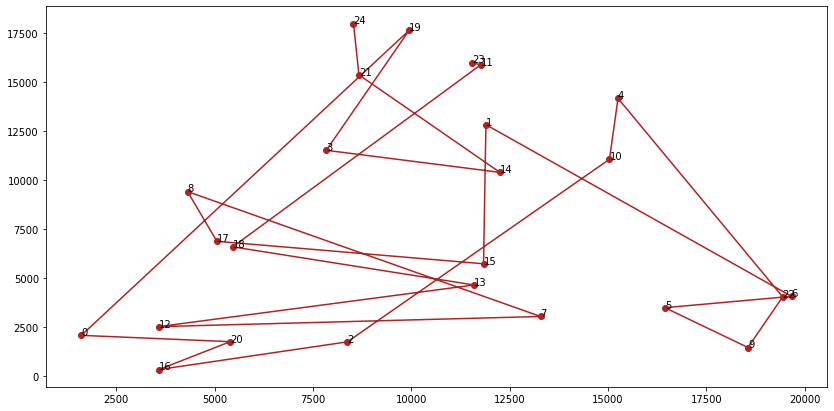

In [40]:
#Obtenemos coordenadas X Y:
xy_cords=np.array(cities_behavior_9[['x', 'y']].values.tolist())

#Graficamos los puntos:
fig, ax = plt.subplots(figsize=(14,7))

for i in range(n):
    ax.annotate(str(i), xy=(xy_cords[i,0], xy_cords[i,1]+0.1))
    
ax.scatter(xy_cords[:,0],xy_cords[:,1],color='firebrick')
ax.plot(xy_cords[orden,0], xy_cords[orden,1],color='firebrick')

A diferencia de lo que creíamos el algoritmo de **mlrose** no está siendo más eficiente. Vale la pena discutir la implementación del algoritmo, el cuál escoge la *mejor ruta* de forma aleatoria. Al incrementar el número de observaciones no nos está entregando un mejor resultado.

Además, para efectos de este problema, podríamos implementar el algoritmo de Santa con un o una ayudante, en este caso, necesitaríamos ayuda de la Señora Claus, para poder hacer más ligero el camino de Santa. 

In [41]:
C=pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)


In [42]:
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))


In [43]:
X = cp.Variable(C.shape, boolean=True)
n = len(C)
u = cp.Variable(n, integer=True)
m = 2
ones = np.ones((n,1))



In [44]:
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

In [45]:
constraints = []
constraints += [X[0,:] @ ones == m]
constraints += [X[:,0] @ ones == m]
constraints += [X[1:,:] @ ones == 1]
constraints += [X[:,1:].T @ ones == 1]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

In [ ]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

74432.42324447841

In [49]:
X_sol = np.argwhere(X.value==1)

ruta = {}
for i in range(0, m):
    ruta['Salesman_' + str(i+1)] = [0]
    j = i
    a = 10e10
    while a != 0:
        a = X_sol[j,1]
        ruta['Salesman_' + str(i+1)].append(a)
        j = np.where(X_sol[:,0] == a)
        j = j[0][0]
        a = j

# Showing the paths
for i in ruta.keys():
    print('The path of ' + i + ' is:\n')
    print( ' => '.join(map(str, ruta[i])))
    print('')

The path of Salesman_1 is:

0 => 12 => 0

The path of Salesman_2 is:

0 => 18 => 17 => 8 => 3 => 21 => 24 => 19 => 23 => 11 => 4 => 1 => 14 => 10 => 6 => 22 => 9 => 5 => 7 => 15 => 13 => 2 => 20 => 16 => 0



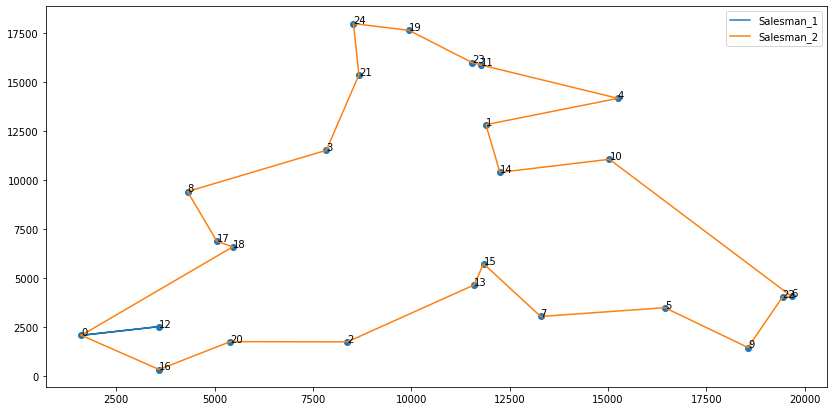

In [50]:
fig, ax = plt.subplots(figsize=(14,7))

for i in range(n):
    ax.annotate(str(i), xy=(xy_cords[i,0], xy_cords[i,1]+0.1))

ax.scatter(xy_cords[:,0],xy_cords[:,1])
for i in ruta.keys():
    ax.plot(xy_cords[ruta[i],0], xy_cords[ruta[i],1], label = i)
    ax.legend(loc='best')

Referencias:

[Solving Travelling Salesperson Problems with Python- How to use randomized optimization algorithms to solve travelling salesperson problems with Python mlrose package](https://towardsdatascience.com/solving-travelling-salesperson-problems-with-python-5de7e883d847)

[Hayes, G. (2019). mlrose: Machine Learning, Randomized Optimization and SEarch package for Python.Accessed: 01-12-2021]
(https://github.com/gkhayes/mlrose)

[El problema del agente viajero: un recorrido sobre su historia, sus aplicaciones y problema relacionados. Un encuentro discreto, Edgar Possani](https://www.itam.mx/sites/default/files/u444/platica_possani.pdf)